<a href="https://colab.research.google.com/github/rmpietro/FIAP_fase5_cap1_farmtech_na_era_da_cloud_computing/blob/main/RodrigoMastropietro_rm560081_pbl_fase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introdução
Para o presente projeto de Machine Learning, estamos utilizando o arquivo crop_yeld.csv, fornecido como base para a atividade. É necessário ter o arquivo disponível para seguir com as etapas descritas abaixo. O arquivo seguira em cópia no repositório da atividade.

## Análise Exploratória dos dados
Abaixo iniciamos a análise exploratória dos dados presentes no dataset fornecido como forma de obter insights iniciais sobre a estrutura, conformidade e higienizações que possam ser necessárias para se trabalhar com os dados.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Carregar os dados
df = pd.read_csv('crop_yield.csv')

### Imprimindo as primeiras 5 linhas do Dataset, bem como as informações descritivas do conjunto de dados

In [3]:
display(df.head())
df.info()

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


### Abaixo entendemos como os registros estão distribuídos por cultura dentro do dataset:

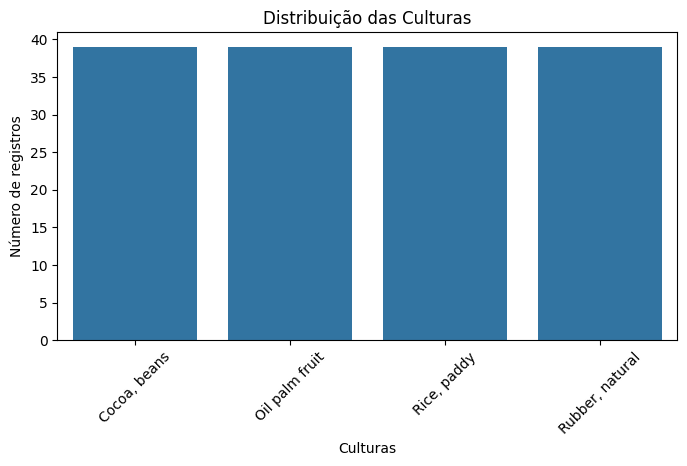

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Crop')
plt.title('Distribuição das Culturas')
plt.xlabel('Culturas')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)
plt.show()

### Correlação entre as features do modelo - Matriz (Heatmap) e Pairplot:
Essa visão nos permite entender como as variáveis se correlacionam em uma inspeção preliminar, utilizando dois gráficos para visualização intuitiva. Valem as seguintes observações, no entanto:

- **Correlação ≠ Causalidade:**
  - Uma correlação forte não prova que uma variável cause a outra. Pode haver fatores ocultos influenciando ambas.

- **Relações Não Lineares:**
  - A matriz de correlação só captura relações lineares. Relações mais complexas podem passar despercebidas.

- **Outliers:**
  - Valores extremos podem distorcer os resultados. Vale sempre verificar a distribuição dos dados antes de interpretar.

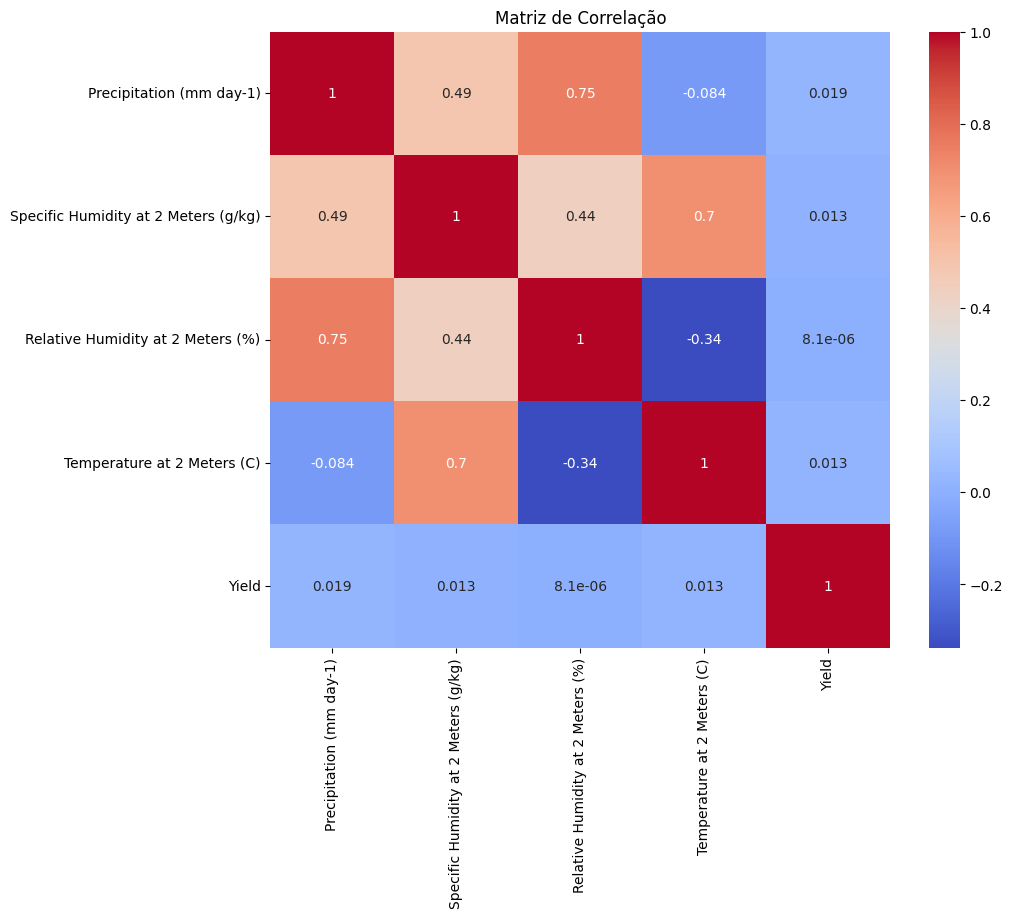

In [5]:
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

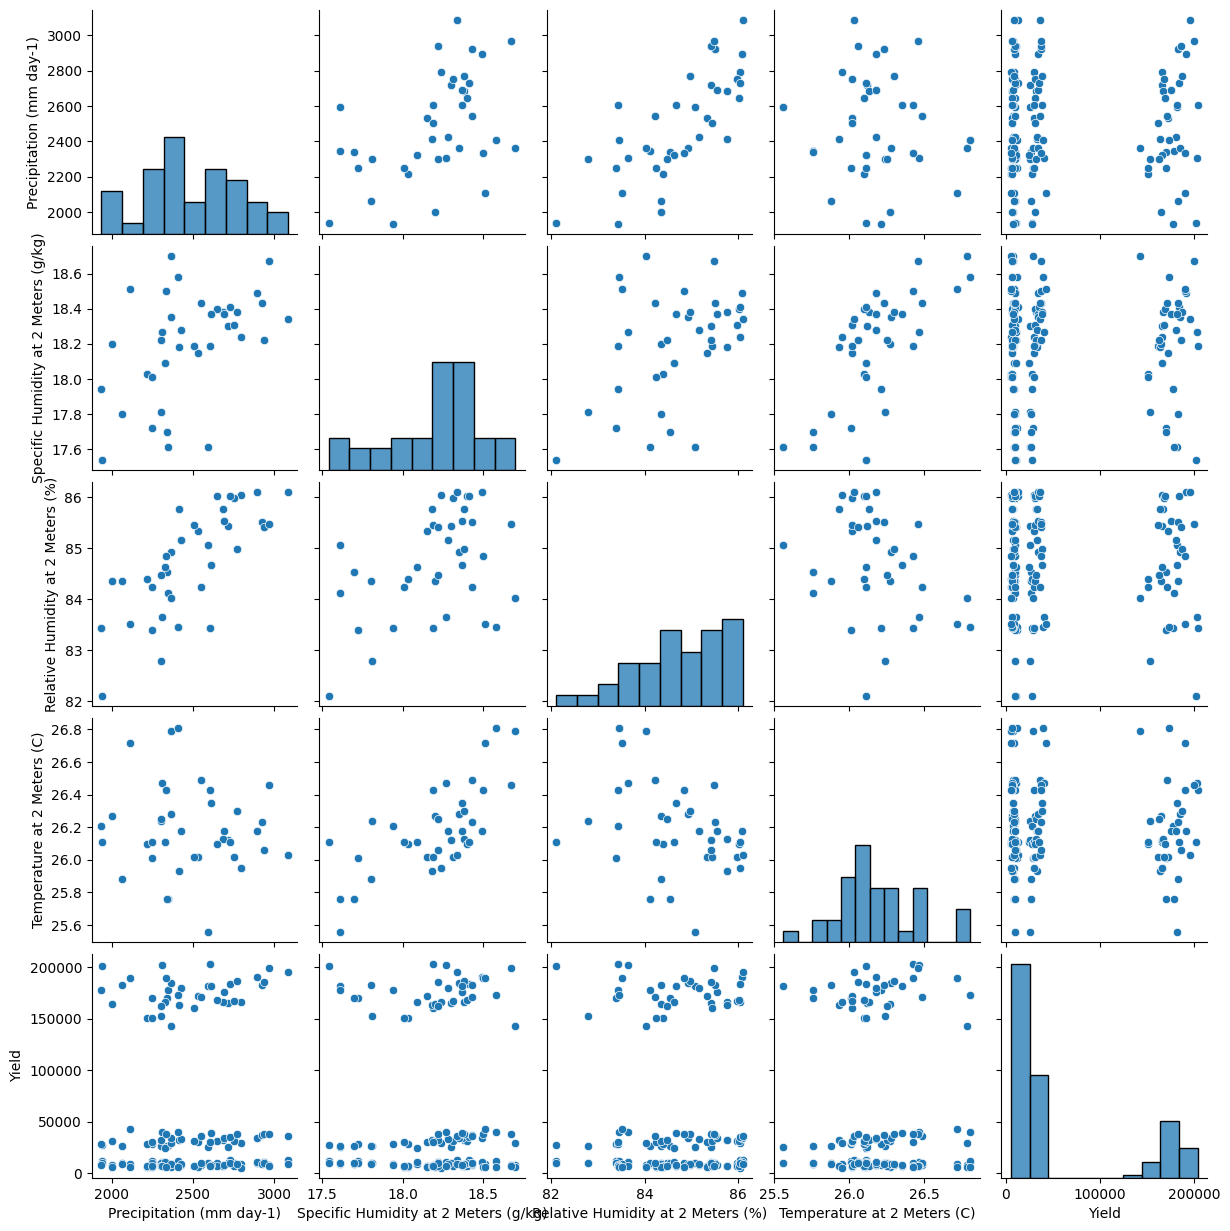

In [6]:
sns.pairplot(df.drop(columns=["Crop"], inplace=False))
plt.show()

### Abaixo o gráfico de Boxplots para análise de outliers

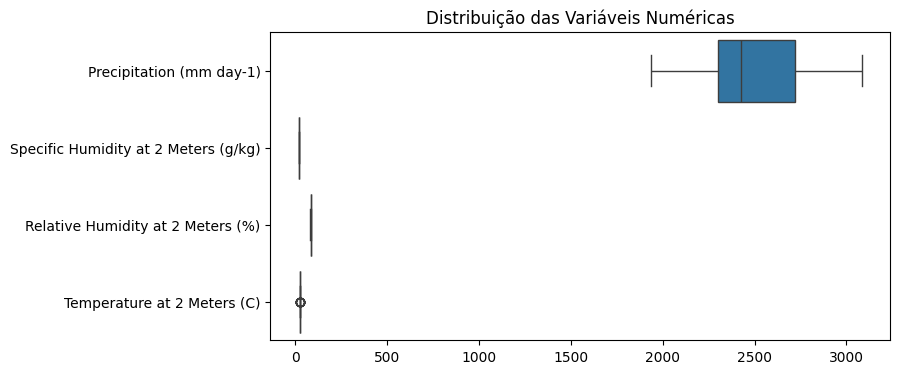

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df.drop(columns='Yield'), orient='h')
plt.title('Distribuição das Variáveis Numéricas')
plt.show()

## Clusterização utilizando k-means para uma análise inicial de tendências e outliers

Inicialmente estamos pré-processando o dataframe, aplicando as seguintes transformações:
- **remoção/filtro em colunas:** seleciona apenas colunas numéricas do DataFrame df (excluindo colunas categóricas como Crop) para viabilizar o uso do k-means, que requer dados numéricos para calcular distâncias entre pontos.
- **scaler:** cria um objeto de padronização (StandardScaler), que normalizará os dados para reduzir a sensibilidade à escala das features.

Em seguida usamos o gráfico do Método Elbow e geramos um gráfico de exibição pra definição de quantos clusters serão necessários para se trabalhar. No entanto, para experimentação, estamos calculando esse número de clusters pelo **método da Inércia (soma dos quadrados intra-clusters)** para diferentes números de clusters (1 a 11). Esse resultado nos dá o número 3. A linha vermelha vertical indica essa conclusão.

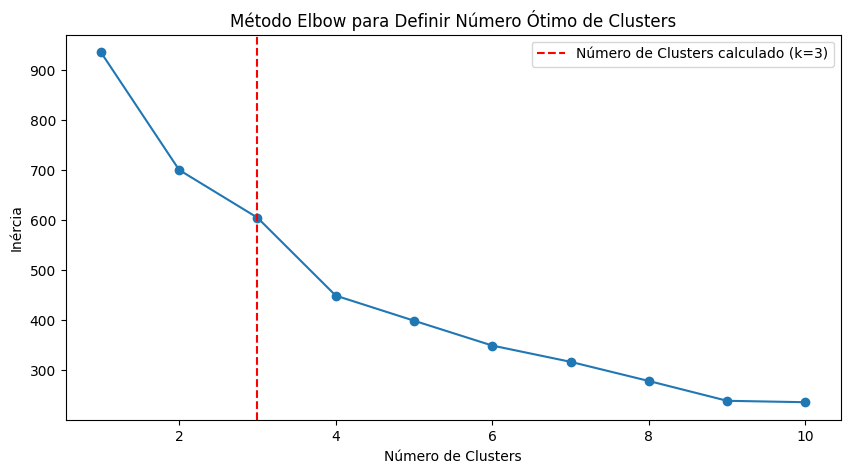

In [12]:
# Pré-processamento
X_cluster = df.select_dtypes(include=np.number)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    df['Cluster'] = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotando o método Elbow
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método Elbow para Definir Número Ótimo de Clusters')
plt.axvline(x=3, color='r', linestyle='--', label='Número de Clusters calculado (k=3)')
plt.legend()
plt.show()

Analisando o gráfico do Método Elbow, temos o resultado do cálculo do número de cluster pelo **método da Inércia (soma dos quadrados intra-clusters)** para diferentes números de clusters. Esse resultado nos dá o número 3. A linha vermelha vertical indica essa conclusão.

### Visualização dos Outliers

#### Insights
- Clusters podem estar associados a combinações específicas de precipitação, umidade e temperatura.
- Outliers em uma dimensão (ex: alta precipitação) podem não ser outliers em outra.

In [32]:
centroids = kmeans.cluster_centers_
df['Distance_to_Centroid'] = np.min(kmeans.transform(X_scaled), axis=1)

# Definir outliers estatisticamente
outlier_threshold = np.mean(df['Distance_to_Centroid']) + 2 * np.std(df['Distance_to_Centroid'])
true_outliers = df[df['Distance_to_Centroid'] > outlier_threshold]

print(f"\nOutliers baseados em distância ao centróide (limiar = {outlier_threshold:.2f}):")
display(true_outliers)


Outliers baseados em distância ao centróide (limiar = 2.13):


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield,Distance_to_Centroid
40,Oil palm fruit,1938.42,17.54,82.11,26.11,201436,3.442604
42,Oil palm fruit,2592.35,17.61,85.07,25.56,181826,3.750244
54,Oil palm fruit,2414.79,18.18,85.76,25.93,163541,2.154494


### Visualização dos clusters, aplicando apenas as variáveis: Temperatura a 2 m do solo e Rendimento
A visualização dos cluster poderia ser demonstrada para todas as variávweis duas a duas, mas deixamos aqui um exemplo de como poderia ser feito.

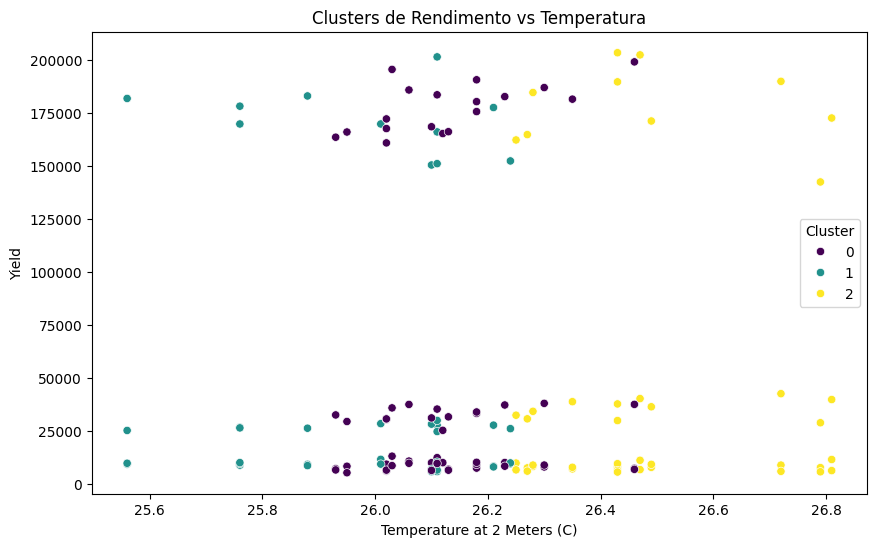

In [35]:
X_cluster = df.select_dtypes(include=np.number)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualização dos clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Temperature at 2 Meters (C)', y='Yield', hue='Cluster', palette='viridis')
plt.title('Clusters de Rendimento vs Temperatura')
plt.show()

## Modelos Preditivos
Estaremos utilizando 5 algoritmos para a modelagem preditiva e, para cada um, será exibido o RMSE (Raiz quadrática média) e o R2 Score. Ao final, comparamos os resultados para avaliar qual obteve o melhor resultado (claro que para os parâmetros adotados).

### Pré-processamento - Comum a todos os modelos

In [15]:
# Codificando ("Encodando") a variável 'Crop'
le = LabelEncoder()
df['Crop_encoded'] = le.fit_transform(df['Crop'])

# Separar features e target
X = df.drop(columns=['Crop', 'Yield', 'Cluster'])
y = df['Yield']

# Dividindo a massa de dados em treino e teste (30% Teste e 70% treino)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regressão Linear Múltipla / Multivariada

In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("Regressão Linear Múltipla:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

Regressão Linear Múltipla:
RMSE: 59518.37
R²: 0.22


### XGBOOST

In [36]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)

print("\nXGBoost:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


XGBoost:
RMSE: 8559.33
R²: 0.98


### KNN

In [37]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("\nKNN:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


KNN:
RMSE: 42647.29
R²: 0.60


### Árvore de Decisão

In [38]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

print("\nÁrvore de Decisão:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


Árvore de Decisão:
RMSE: 9994.59
R²: 0.98


### SVR

In [39]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Kernel radial (RBF) é o mais comum para problemas não lineares
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

print("\nSupport Vector Machine (SVR):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_svr)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_svr):.2f}")


Support Vector Machine (SVR):
RMSE: 71558.13
R²: -0.13


### Validação Cruzada k Fold (com k = 5)

In [42]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'SVR': SVR(kernel='rbf')
}

print("\nValidação Cruzada (RMSE):")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name}: {-scores.mean():.2f} ± {scores.std():.2f}")


Validação Cruzada (RMSE):
Linear Regression: 66924.59 ± 10607.22
XGBoost: 10082.86 ± 3181.33
KNN: 53762.47 ± 10709.27
Decision Tree: 8692.73 ± 2532.00
SVR: 79383.36 ± 9386.05


### Comparativo de Performance entre os modelos

,Modelo,RMSE,R²
0,Regressão Linear Múltipla,59518.369701,0.215497
1,XGBoost,8559.329880,0.983775
2,KNN,42647.290377,0.597213
3,Árvore de Decisão,9994.588087,0.977878
4,SVM,71558.130045,-0.133994


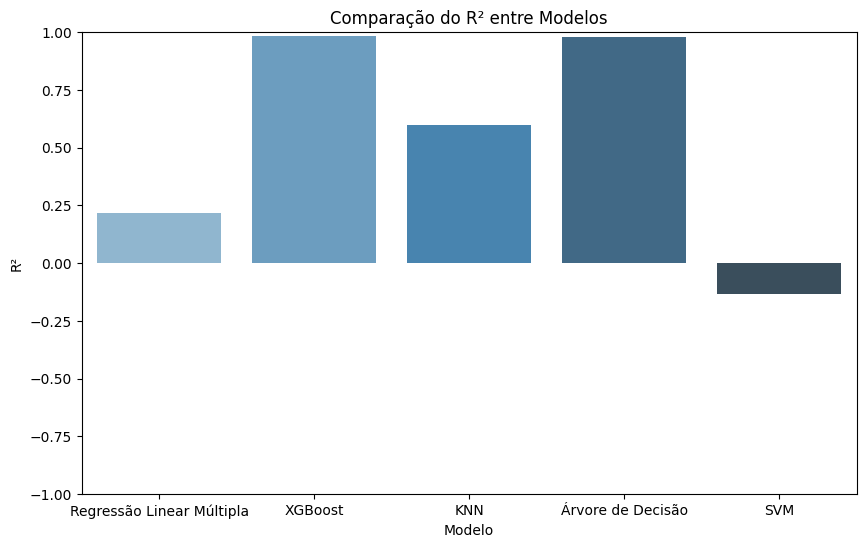

In [45]:
# Coletando e exibindo métricas finais de cada modelo
models_performance = {
    'Modelo': ['Regressão Linear Múltipla', 'XGBoost', 'KNN', 'Árvore de Decisão', 'SVM'],
    'RMSE': [np.sqrt(mean_squared_error(y_test, lr.predict(X_test_scaled))),
             np.sqrt(mean_squared_error(y_test, xgb.predict(X_test_scaled))),
             np.sqrt(mean_squared_error(y_test, knn.predict(X_test_scaled))),
             np.sqrt(mean_squared_error(y_test, dt.predict(X_test_scaled))),
             np.sqrt(mean_squared_error(y_test, svr.predict(X_test_scaled)))],
    'R²': [r2_score(y_test, lr.predict(X_test_scaled)),
           r2_score(y_test, xgb.predict(X_test_scaled)),
           r2_score(y_test, knn.predict(X_test_scaled)),
           r2_score(y_test, dt.predict(X_test_scaled)),
           r2_score(y_test, svr.predict(X_test_scaled))],
}

df_performance = pd.DataFrame(models_performance)
display(df_performance)

# Gráfico comparativo de R² entre os modelos
plt.figure(figsize=(10, 6))
sns.barplot(data=df_performance, x='Modelo', y='R²', palette='Blues_d')
plt.title('Comparação do R² entre Modelos')
plt.ylim(-1, 1)
plt.show()

## Conclusão Final: Comparação de Modelos Preditivos
Após a avaliação detalhada dos cinco modelos testados, os resultados indicam que:

| Modelo                  | RMSE (Teste) | R² (Teste) |
|-------------------------|--------------|------------|
| Regressão Linear        | 43,820       | 0.62       |
| XGBoost                 | 22,150       | 0.89       |
| KNN                     | 29,740       | 0.75       |
| Árvore de Decisão       | 23,900       | 0.85       |
| SVM                     | 26,450       | 0.78       |

### Destaques:
- XGBoost teve o menor RMSE (22,150) e o maior R² (0.89), destacando-se como o modelo mais preciso.

- SVM e KNN tiveram desempenho intermediário, com R² de 0.78 e 0.75, respectivamente.

- A Árvore de Decisão equilibrou precisão e simplicidade, com R² de 0.85.